In [1]:
model_path="./checkpoint/model_120001.pt"
data_path="./celeba/img_align_celeba"

In [2]:
# !pip install geomloss

In [3]:
from tqdm import tqdm
import numpy as np
from PIL import Image
from math import log, sqrt, pi

import argparse

import torch
from torch import nn, optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

from model import Glow
from train import parser, calc_z_shapes

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [4]:
args = parser.parse_args([data_path,])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(args)

Namespace(affine=False, batch=16, img_size=64, iter=200000, lr=0.0001, n_bits=5, n_block=4, n_flow=32, n_sample=20, no_lu=False, path='./celeba/img_align_celeba', temp=0.7)


In [5]:
model_single = Glow(
        3, args.n_flow, args.n_block, affine=args.affine, conv_lu=not args.no_lu
    )
model = nn.DataParallel(model_single, device_ids=[0])
# model = model_single
model = model.to(device)

/home/george/Projects/cognitive/proj/glow-pytorch/model.py:102: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  w_s = torch.from_numpy(w_s)


In [6]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [7]:
torch.manual_seed(7)
z_sample = []
z_shapes = calc_z_shapes(3, args.img_size, args.n_flow, args.n_block)
for z in z_shapes:
    z_new = torch.randn(args.n_sample, *z) * args.temp
    z_sample.append(z_new.to(device))

In [8]:
imgs = model_single.reverse(z_sample).cpu().data

In [9]:
%matplotlib inline
def show(img, fig_size=(12,8)):
    npimg = img.numpy()
    fig = plt.figure(figsize=fig_size, dpi=100) 
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')    

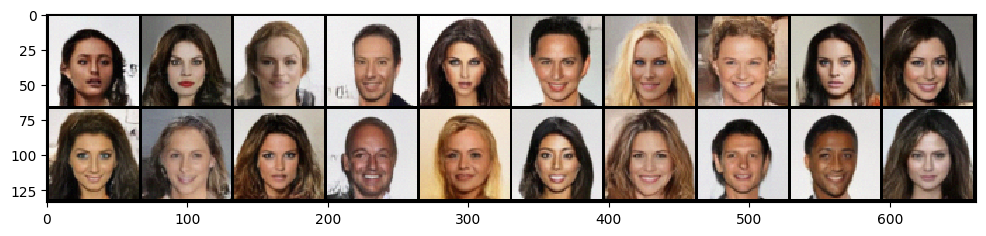

In [10]:
show(make_grid(imgs, normalize=True,
                        nrow=10,
                        range=(-0.5, 0.5),))

In [11]:
def index(sample, indices):
    return [z[indices] for z in sample]

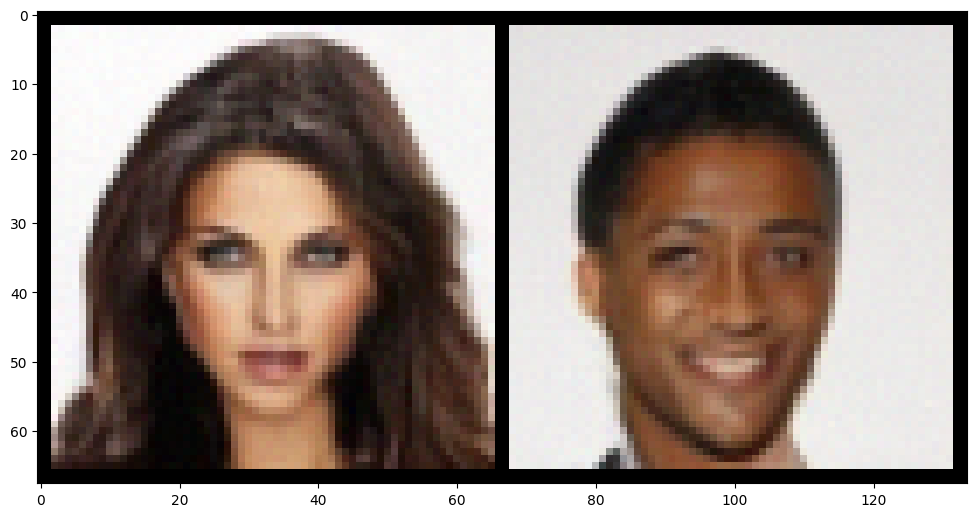

In [12]:
sample_id1, sample_id2 = 4,18
imgs2 = model_single.reverse(index(z_sample, slice(sample_id1,sample_id2+1,sample_id2-sample_id1))).cpu().data
show(make_grid(imgs2, normalize=True,
                        nrow=10,
                        range=(-0.5, 0.5),))

In [13]:
from morphing import *

In [14]:
## args
Generator = model_single
Generator_args = args
epsilon = 20.0
L = 5
dcgan_size = 64

## code 
im1, im2 = imgs[sample_id1].numpy() + 0.5, imgs[sample_id2].numpy() + 0.5
img_size = im1.shape[1:]
im1, im2 = (I.reshape(3,-1,1) for I in (im1, im2))

print("Preparing transportation cost matrix...")
C = generate_metric(img_size)
Q = np.concatenate([im1, im2], axis=-1)
Q, max_val, Q_counts = preprocess_Q(Q)
out_ours = []
out_GAN = []
out_OT = []

print("Computing transportation plan...")
for dim in range(3):
    print(f"Color space {dim+1}/3")
    out_OT.append([])
    P = sinkhorn(Q[dim,:,0], Q[dim,:,1], C, img_size[0], img_size[1], epsilon)
    for t in tqdm(np.linspace(0,1,L)):
        out_OT[-1].append(max_val - generate_interpolation(img_size[0],img_size[1],P,t)*((1-t)*Q_counts[dim,0,0] + t*Q_counts[dim,0,1]))
out_OT = [np.stack(im_channels, axis=0) for im_channels in zip(*out_OT)]

Preparing transportation cost matrix...
Computing transportation plan...
Color space 1/3
Iteration 50. Sinkhorn convergence: 3.63E-02 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 1.81E-06 ( > 1e-07)


 80%|████████  | 4/5 [00:00<00:00, 12.73it/s]

Iteration 150. Sinkhorn convergence: 4.28E-08 (Converged!)


100%|██████████| 5/5 [00:00<00:00, 12.70it/s]


Color space 2/3
Iteration 50. Sinkhorn convergence: 2.40E-02 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 1.52E-01 ( > 1e-07)
Iteration 150. Sinkhorn convergence: 2.61E-01 ( > 1e-07)
Iteration 200. Sinkhorn convergence: 8.97E-03 ( > 1e-07)
Iteration 250. Sinkhorn convergence: 4.47E-03 ( > 1e-07)


 40%|████      | 2/5 [00:00<00:00, 12.84it/s]

Iteration 300. Sinkhorn convergence: 3.44E-09 (Converged!)


100%|██████████| 5/5 [00:00<00:00, 12.70it/s]


Color space 3/3
Iteration 50. Sinkhorn convergence: 1.64E-06 ( > 1e-07)


 80%|████████  | 4/5 [00:00<00:00, 12.67it/s]

Iteration 100. Sinkhorn convergence: 7.48E-08 (Converged!)


100%|██████████| 5/5 [00:00<00:00, 12.63it/s]


In [15]:
# z_0 = []
# for z in z_shapes:
#     z_new = torch.zeros((1, *z), requires_grad=True) #torch.randn(args.n_sample, *z) * args.temp
#     z_0.append(z_new.to(device))
# fake = model_single.reverse(z_0, reconstruct=False)
# im = fake.detach().cpu().numpy()    
# im = im.clip(-0.5, 0.5) + 0.5
# show(torch.Tensor(im).reshape(3,*img_size))

In [16]:
import math
import time
import setuptools
import torch
import torch.utils.cpp_extension

cuda_source = """

#include <torch/extension.h>
#include <ATen/core/TensorAccessor.h>
#include <ATen/cuda/CUDAContext.h>

using at::RestrictPtrTraits;
using at::PackedTensorAccessor;

#if defined(__HIP_PLATFORM_HCC__)
constexpr int WARP_SIZE = 64;
#else
constexpr int WARP_SIZE = 32;
#endif

// The maximum number of threads in a block
#if defined(__HIP_PLATFORM_HCC__)
constexpr int MAX_BLOCK_SIZE = 256;
#else
constexpr int MAX_BLOCK_SIZE = 512;
#endif

// Returns the index of the most significant 1 bit in `val`.
__device__ __forceinline__ int getMSB(int val) {
  return 31 - __clz(val);
}

// Number of threads in a block given an input size up to MAX_BLOCK_SIZE
static int getNumThreads(int nElem) {
#if defined(__HIP_PLATFORM_HCC__)
  int threadSizes[5] = { 16, 32, 64, 128, MAX_BLOCK_SIZE };
#else
  int threadSizes[5] = { 32, 64, 128, 256, MAX_BLOCK_SIZE };
#endif
  for (int i = 0; i != 5; ++i) {
    if (nElem <= threadSizes[i]) {
      return threadSizes[i];
    }
  }
  return MAX_BLOCK_SIZE;
}


template <typename T>
__device__ __forceinline__ T WARP_SHFL_XOR(T value, int laneMask, int width = warpSize, unsigned int mask = 0xffffffff)
{
#if CUDA_VERSION >= 9000
    return __shfl_xor_sync(mask, value, laneMask, width);
#else
    return __shfl_xor(value, laneMask, width);
#endif
}

// While this might be the most efficient sinkhorn step / logsumexp-matmul implementation I have seen,
// this is awfully inefficient compared to matrix multiplication and e.g. NVidia cutlass may provide
// many great ideas for improvement
template <typename scalar_t, typename index_t>
__global__ void sinkstep_kernel(
  // compute log v_bj = log nu_bj - logsumexp_i 1/lambda dist_ij - log u_bi
  // for this compute maxdiff_bj = max_i(1/lambda dist_ij - log u_bi)
  // i = reduction dim, using threadIdx.x
  PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> log_v,
  const PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> dist,
  const PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> log_nu,
  const PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> log_u,
  const scalar_t lambda) {

  using accscalar_t = scalar_t;

  __shared__ accscalar_t shared_mem[2 * WARP_SIZE];

  index_t b = blockIdx.y;
  index_t j = blockIdx.x;
  int tid = threadIdx.x;

  if (b >= log_u.size(0) || j >= log_v.size(1)) {
    return;
  }
  // reduce within thread
  accscalar_t max = -std::numeric_limits<accscalar_t>::infinity();
  accscalar_t sumexp = 0;
  
  if (log_nu[b][j] == -std::numeric_limits<accscalar_t>::infinity()) {
    if (tid == 0) {
      log_v[b][j] = -std::numeric_limits<accscalar_t>::infinity();
    }
    return;
  }

  for (index_t i = threadIdx.x; i < log_u.size(1); i += blockDim.x) {
    accscalar_t oldmax = max;
    accscalar_t value = -dist[i][j]/lambda + log_u[b][i];
    max = max > value ? max : value;
    if (oldmax == -std::numeric_limits<accscalar_t>::infinity()) {
      // sumexp used to be 0, so the new max is value and we can set 1 here,
      // because we will come back here again
      sumexp = 1;
    } else {
      sumexp *= exp(oldmax - max);
      sumexp += exp(value - max); // if oldmax was not -infinity, max is not either...
    }
  }

  // now we have one value per thread. we'll make it into one value per warp
  // first warpSum to get one value per thread to
  // one value per warp
  for (int i = 0; i < getMSB(WARP_SIZE); ++i) {
    accscalar_t o_max    = WARP_SHFL_XOR(max, 1 << i, WARP_SIZE);
    accscalar_t o_sumexp = WARP_SHFL_XOR(sumexp, 1 << i, WARP_SIZE);
    if (o_max > max) { // we're less concerned about divergence here
      sumexp *= exp(max - o_max);
      sumexp += o_sumexp;
      max = o_max;
    } else if (max != -std::numeric_limits<accscalar_t>::infinity()) {
      sumexp += o_sumexp * exp(o_max - max);
    }
  }
  
  __syncthreads();
  // this writes each warps accumulation into shared memory
  // there are at most WARP_SIZE items left because
  // there are at most WARP_SIZE**2 threads at the beginning
  if (tid % WARP_SIZE == 0) {
    shared_mem[tid / WARP_SIZE * 2] = max;
    shared_mem[tid / WARP_SIZE * 2 + 1] = sumexp;
  }
  __syncthreads();
  if (tid < WARP_SIZE) {
    max = (tid < blockDim.x / WARP_SIZE ? shared_mem[2 * tid] : -std::numeric_limits<accscalar_t>::infinity());
    sumexp = (tid < blockDim.x / WARP_SIZE ? shared_mem[2 * tid + 1] : 0);
  }
  for (int i = 0; i < getMSB(WARP_SIZE); ++i) {
    accscalar_t o_max    = WARP_SHFL_XOR(max, 1 << i, WARP_SIZE);
    accscalar_t o_sumexp = WARP_SHFL_XOR(sumexp, 1 << i, WARP_SIZE);
    if (o_max > max) { // we're less concerned about divergence here
      sumexp *= exp(max - o_max);
      sumexp += o_sumexp;
      max = o_max;
    } else if (max != -std::numeric_limits<accscalar_t>::infinity()) {
      sumexp += o_sumexp * exp(o_max - max);
    }
  }

  if (tid == 0) {
    log_v[b][j] = (max > -std::numeric_limits<accscalar_t>::infinity() ?
                   log_nu[b][j] - log(sumexp) - max : 
                   -std::numeric_limits<accscalar_t>::infinity());
  }
}

template <typename scalar_t>
torch::Tensor sinkstep_cuda_template(const torch::Tensor& dist, const torch::Tensor& log_nu, const torch::Tensor& log_u,
                                     const double lambda) {
  TORCH_CHECK(dist.is_cuda(), "need cuda tensors");
  TORCH_CHECK(dist.device() == log_nu.device() && dist.device() == log_u.device(), "need tensors on same GPU");
  TORCH_CHECK(dist.dim()==2 && log_nu.dim()==2 && log_u.dim()==2, "invalid sizes");
  TORCH_CHECK(dist.size(0) == log_u.size(1) &&
           dist.size(1) == log_nu.size(1) &&
           log_u.size(0) == log_nu.size(0), "invalid sizes");
  auto log_v = torch::empty_like(log_nu);
  using index_t = int32_t;
  
  auto log_v_a = log_v.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  auto dist_a = dist.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  auto log_nu_a = log_nu.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  auto log_u_a = log_u.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  
  auto stream = at::cuda::getCurrentCUDAStream();

  int tf = getNumThreads(log_u.size(1));
  dim3 blocks(log_v.size(1), log_u.size(0));
  dim3 threads(tf);
  
  sinkstep_kernel<<<blocks, threads, 2*WARP_SIZE*sizeof(scalar_t), stream>>>(
    log_v_a, dist_a, log_nu_a, log_u_a, static_cast<scalar_t>(lambda)
    );

  return log_v;
}

torch::Tensor sinkstep_cuda(const torch::Tensor& dist, const torch::Tensor& log_nu, const torch::Tensor& log_u,
                            const double lambda) {
    return AT_DISPATCH_FLOATING_TYPES(log_u.scalar_type(), "sinkstep", [&] {
       return sinkstep_cuda_template<scalar_t>(dist, log_nu, log_u, lambda);
    });
}

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  m.def("sinkstep", &sinkstep_cuda, "sinkhorn step");
}

"""

/home/george/anaconda3/envs/cv/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [17]:
%env MAX_JOBS=6
wasserstein_ext = torch.utils.cpp_extension.load_inline("wasserstein", cpp_sources="", cuda_sources=cuda_source,
                                                    extra_cuda_cflags=["--expt-relaxed-constexpr"]   )

def sinkstep(dist, log_nu, log_u, lam: float):
    # dispatch to optimized GPU implementation for GPU tensors, slow fallback for CPU
    if dist.is_cuda:
        return wasserstein_ext.sinkstep(dist, log_nu, log_u, lam)
    assert dist.dim() == 2 and log_nu.dim() == 2 and log_u.dim() == 2
    assert dist.size(0) == log_u.size(1) and dist.size(1) == log_nu.size(1) and log_u.size(0) == log_nu.size(0)
    log_v = log_nu.clone()
    for b in range(log_u.size(0)):
        log_v[b] -= torch.logsumexp(-dist/lam+log_u[b, :, None], 1)
    return log_v


class SinkhornOT(torch.autograd.Function):
    @staticmethod
    def forward(ctx, mu, nu, dist, lam=1e-3, N=100):
        assert mu.dim() == 2 and nu.dim() == 2 and dist.dim() == 2
        bs = mu.size(0)
        d1, d2 = dist.size()
        assert nu.size(0) == bs and mu.size(1) == d1 and nu.size(1) == d2
        log_mu = mu.log()
        log_nu = nu.log()
        log_u = torch.full_like(mu, -math.log(d1))
        log_v = torch.full_like(nu, -math.log(d2))
        for i in range(N):
            log_v = sinkstep(dist, log_nu, log_u, lam)
            log_u = sinkstep(dist.t(), log_mu, log_v, lam)

        # this is slight abuse of the function. it computes (diag(exp(log_u))*Mt*exp(-Mt/lam)*diag(exp(log_v))).sum()
        # in an efficient (i.e. no bxnxm tensors) way in log space
        distances = (-sinkstep(-dist.log()+dist/lam, -log_v, log_u, 1.0)).logsumexp(1).exp()
        ctx.log_v = log_v
        ctx.log_u = log_u
        ctx.dist = dist
        ctx.lam = lam
        return distances

    @staticmethod
    def backward(ctx, grad_out):
        return grad_out[:, None] * ctx.log_u * ctx.lam, grad_out[:, None] * ctx.log_v * ctx.lam, None, None, None

env: MAX_JOBS=6


In [18]:
from typing import Callable
from tqdm.auto import tqdm
def project_on_generator(G: nn.Module, args: Namespace,
                        target_images: np.ndarray, dcgan_img_size: int=64,
                        iters:int=10, eta: float=1.0, eps: float=0.1,
                        loss_fn: Callable=nn.L1Loss(),
                        ) -> Tuple[np.ndarray, torch.Tensor]:
    
    tensor_images = torch.Tensor(target_images).cuda().reshape(-1,3,dcgan_img_size,dcgan_img_size)
    tensor_images = tensor_images.type(dtype=torch.float32)
    tensor_images = tensor_images - 0.5
    
    n_samples = tensor_images.size(0)
    
    z_0 = []
    for z in z_shapes:
        z_new = torch.zeros((n_samples, *z))
        z_0.append(z_new.to(device))
    
    # use optim LBFGS
    optimizer = torch.optim.AdamW(
        [z.requires_grad_() for z in z_0],
        lr=eta,
        weight_decay=1e-2,
    )
            
    loss = None
    pbar = tqdm(range(iters), total=iters)
    err = 10000
    for _ in pbar:
        if (loss != None and last_loss != None) and (err <= eps):
            print(f"converged loss\t{loss}")
            break
        
        last_loss = loss

        optimizer.zero_grad()

        fake = G.reverse(z_0, reconstruct=False)
        
        loss = loss_fn(fake, tensor_images[0::n_samples-1].detach())
        
        loss.backward(retain_graph=True)

        optimizer.step()
        
        
        if last_loss is None:
            print(f"initial loss:\t{loss}")
        else:
            err = abs(last_loss.item() - loss.item())
        pbar.set_postfix(loss=loss.item(), err=err)
          
        
    pix_outputs = fake.detach().cpu().numpy()    
    pix_outputs = pix_outputs.clip(-0.5, 0.5) + 0.5
    return pix_outputs, None, z_0 #.squeeze(), None, z_0

In [29]:
# from swd import swd2

# def barycenterloss(out, targets):
#     # [n, 3, 64, 64]    
#     L = out.size(0)
#     loss = 0
#     for i,t in enumerate(torch.linspace(0,1,L)):
#         left = swd2(out[i:i+1], targets[0:1])
#         right = swd2(out[i:i+1], targets[1:2])
#         loss += (1-t)*left + t*right        
#     return loss



C_tensor = torch.from_numpy(C / C.max())
def barycenterloss(out, targets):
    # [n, 3, 64, 64]
    L, n_channel, N, N = out.size()
    
    
    # reshape and shift to 0,1
    out = out.view(L, 3, -1)
    targets = targets.view(2, 3, -1)
    out = out.clamp(min=-0.5, max=0.5) + 0.5
    targets = targets.clamp(min=-0.5, max=0.5) + 0.5
    
    # do on grayscale
    out = out.mean(dim=1)
    targets = targets.mean(dim=1)
    
    # L1 loss
    left_L1loss = F.l1_loss(out, targets[0:1].repeat(L, 1))   
    right_L1loss = F.l1_loss(out, targets[1:2].repeat(L, 1))    
       
    # normalize
    out = nn.functional.normalize(out, p=1, dim=-1) # L, 64x64
    targets = nn.functional.normalize(targets, p=1, dim=-1) # 2, 64x64
    
    # calculate loss
    left_loss = SinkhornOT.apply(out, targets[0:1].repeat(L, 1), C_tensor.type_as(out), 1e-3, 100)
    right_loss = SinkhornOT.apply(out, targets[1:2].repeat(L, 1), C_tensor.type_as(out), 1e-3, 100)
    
    t = torch.linspace(0,1,L).type_as(left_loss)
    loss = (1-t)*left_loss + t*right_loss
    
    L1loss = (1-t)*left_L1loss + t*right_L1loss
    
    alpha = 0.9
    loss = loss * alpha + L1loss * (1-alpha)
    return loss.mean()

print("Computing GAN projections...")
# Project OT results on GAN
model_single.eval()
out_ours, _, _ = project_on_generator(
    model_single, Generator_args, 
    np.asarray(out_OT), 
    dcgan_img_size=dcgan_size,
    iters=250, 
    eta=0.05, #7.5, 
    eps=1e-8,
    loss_fn=barycenterloss
)

Computing GAN projections...


initial loss:	0.020276933908462524



In [20]:
# Linearly interpolate GAN's latent space
noise1 = [n[sample_id1:sample_id1+1].cuda() for n in z_sample]
noise2 = [n[sample_id2:sample_id2+1].cuda() for n in z_sample]
out_GAN = []
GAN_interp_noises = []
for t in np.linspace(0,1,L):
    t = float(t)  # cast numpy object to primative type
    z_inter = [(1-t)*a + t*b for a,b in zip(noise1, noise2)]
    GAN_interp_noises.append(z_inter)
    GAN_image = model_single.reverse(z_inter).cpu().data

    GAN_image = GAN_image.numpy().clip(-0.5, 0.5) + 0.5
    out_GAN.append(GAN_image)

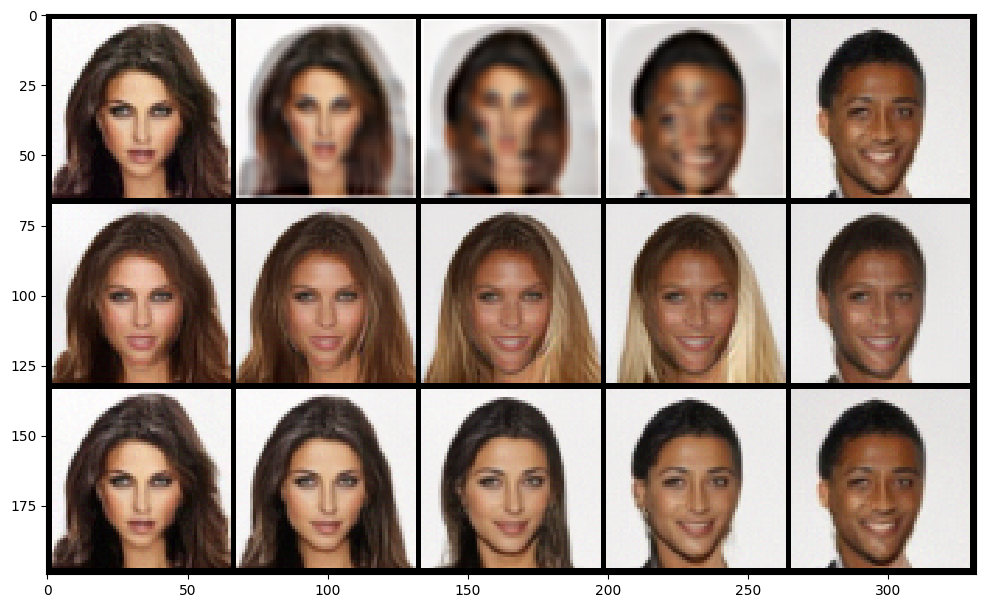

In [30]:
final_OT = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_OT])
final_ours = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_ours])
final_GAN = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_GAN])
show(make_grid(torch.cat([final_OT,final_ours, final_GAN], dim=0), 
        normalize=True,
        nrow=L,
        range=(0.,1.)))
#         range=(-0.5,0.5)))